In [ ]:
from google.colab import files
uploaded = files.upload()

Saving balanced_test_data_updated.csv to balanced_test_data_updated.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving balanced_train_data_updated.csv to balanced_train_data_updated.csv


# Import Library and load the data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load your datasets
train_df = pd.read_csv('balanced_train_data_updated.csv')
test_df = pd.read_csv('balanced_test_data_updated.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing Function to clean the text for tokenization

In [ ]:

# Optional: Combine for a fresh train-test split
# full_df = pd.concat([train_df, test_df], ignore_index=True)
# X = full_df['review']  # or your text column
# y = full_df['sentiment']  # label column
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Or use provided split
X_train = train_df['Text']
y_train = train_df['Score']
X_test = test_df['Text']
y_test = test_df['Score']

# Optional preprocessing function
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# RandomForest Scores with TF-IDF

In [ ]:
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

# Pipeline with TF-IDF and Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [ ]:
# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7624594457256773
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.78      8527
           1       0.75      0.68      0.72      8528
           2       0.77      0.82      0.79      8528

    accuracy                           0.76     25583
   macro avg       0.76      0.76      0.76     25583
weighted avg       0.76      0.76      0.76     25583



# Using Spacy to Clean the text but keeping puncuation

In [ ]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def clean_text_spacy(text):
    doc = nlp(text.lower())  # lowercase + tokenize

    tokens = []
    for token in doc:
        if token.is_space:
            continue
        if token.is_stop and token.text not in ["not", "n't"]:
            continue
        if token.is_punct:
            tokens.append(token.text)  # optionally keep punctuation
        elif token.like_num:
            continue
        else:
            tokens.append(token.lemma_)  # lemmatize

    return ' '.join(tokens)


# RandomForest (Keeping Punctuations) Scores with TF-IDF

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # disable unused components

# Efficient batch cleaning function using nlp.pipe
def spacy_clean_pipe(texts):
    cleaned_texts = []
    for doc in nlp.pipe(texts.str.lower(), batch_size=1000):
        tokens = [
            token.text for token in doc
            if not token.is_space and (not token.is_stop or token.text in ["not", "n't"])
        ]
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

In [ ]:
X_train2 = train_df['Text']
y_train2 = train_df['Score']
X_test2 = test_df['Text']
y_test2 = test_df['Score']


# Clean text using spaCy
X_train2_small_clean = spacy_clean_pipe(X_train2)
X_test2_small_clean = spacy_clean_pipe(X_test2)

# Build pipeline with TF-IDF + Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [ ]:
# Train the model
pipeline.fit(X_train2_small_clean, y_train2)

# Predict and evaluate
y_pred2 = pipeline.predict(X_test2_small_clean)
print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))

Accuracy: 0.7605050228667475
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.78      8527
           1       0.76      0.66      0.70      8528
           2       0.77      0.83      0.80      8528

    accuracy                           0.76     25583
   macro avg       0.76      0.76      0.76     25583
weighted avg       0.76      0.76      0.76     25583



# Comparing the Results for TF-IDF with and without Punctuations

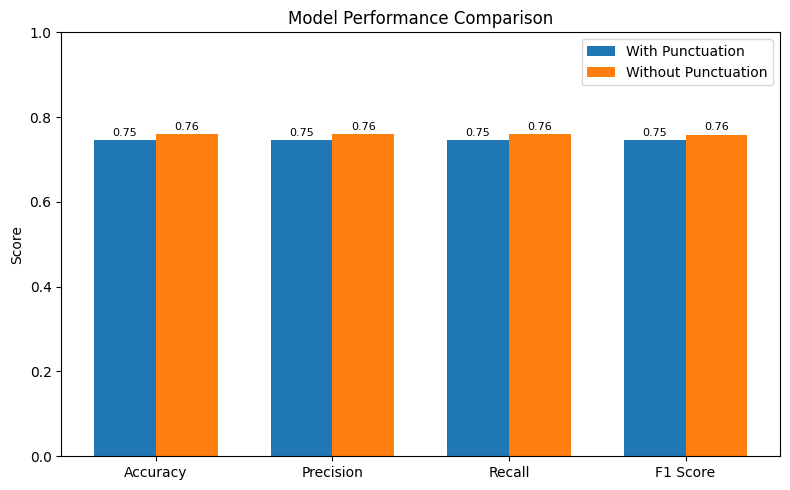

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


metrics_with = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}

metrics_without = {
    'Accuracy': accuracy_score(y_test, y_pred2),
    'Precision': precision_score(y_test, y_pred2, average='weighted', zero_division=0),
    'Recall': recall_score(y_test, y_pred2, average='weighted', zero_division=0),
    'F1 Score': f1_score(y_test, y_pred2, average='weighted', zero_division=0)
}

# 📊 Plotting
labels = list(metrics_with.keys())
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, metrics_with.values(), width, label='With Punctuation')
bar2 = ax.bar(x + width/2, metrics_without.values(), width, label='Without Punctuation')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1)  # all metrics are between 0–1

# Adding value labels
for bar in bar1 + bar2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()